In [ ]:
import pandas as pd   
# parquet_file = 'location\to\file\example_pa.parquet'
file = '../模型/WeatherDelay/WeatherDelay_Group30_dataset.parquet'
dataset = pd.read_parquet(file, engine='pyarrow');dataset

In [ ]:
df = dataset.groupby('WeatherDelayGroups30').sample(n=7442, random_state=2)

col_select =['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek',
# 'IATA_Code_Marketing_Airline', 
 'Airline_AA',
 'Airline_AS',
 'Airline_B6',
 'Airline_DL',
 'Airline_F9',
 'Airline_G4',
 'Airline_HA',
 'Airline_NK',
 'Airline_UA',
 'Airline_VX',
 'Airline_WN',
'Origin', 'Dest',
'CRSDepTime',
'CRSArrTime', 
'Distance',
'AWND',
'PRCP',
'TMAX',
'TMIN',
'WSF2',
'WSF5',
'SNOW',
'WT01',
'WT02',
'WT03',
'WT04',
'WT05',
'WT06',
'WT07',
'WT08',
'WT09',
'WT10',
'WT11',
'WT18',
'WeatherDelayGroups30']

df2 = df[col_select]

# y = dataset['ArrivalDelayGroups']
y = df2['WeatherDelayGroups30']
# X = dataset.loc[:, dataset.columns != 'ArrivalDelayGroups'] #select all columns but not the labels
X = df2.loc[:, ~df2.columns.isin(['ArrivalDelayGroups','ArrivalDelayGroups30','WeatherDelay','WeatherDelayGroups30'])]

#### NORMALIZE X ####

# Normalize so everything is on the same scale. 
from sklearn import preprocessing
cols = X.columns
# min_max_scaler = preprocessing.MinMaxScaler()
scaler = preprocessing.StandardScaler()
# np_scaled = min_max_scaler.fit_transform(X)
np_scaled = scaler.fit_transform(X)

# new data frame with the new scaled data. 
X = pd.DataFrame(np_scaled, columns = cols)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y = y_train  #provide your own target name
)
print(sample_weights.size)
pd.Series(sample_weights).value_counts()

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Final model
xgb = XGBClassifier(objective= 'multi:softmax', num_class = 7 ,n_estimators=1000, learning_rate=0.05,n_jobs=-1, max_depth = 10)
# xgb = XGBClassifier(objective= 'multi:softproba', num_class = 7 ,n_estimators=1000, learning_rate=0.05,n_jobs=-1, max_depth = 10)

# xgb = XGBClassifier(n_estimators=100, learning_rate=0.05,n_jobs=-1, max_depth = 3,max_delta_step=1)
xgb.fit(X_train, y_train,sample_weight=sample_weights)
# xgb.fit(X_train, y_train)


y_pred = xgb.predict(X_test)


from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
print('Accuracy', ':', round(accuracy_score(y_test, y_pred), 5), '\n')
print('Accuracy', ':', round(balanced_accuracy_score(y_test, y_pred), 5), '\n')

# Confusion Matrix
confusion_matr = confusion_matrix(y_test, y_pred) #normalize = 'true'
plt.figure(figsize = (16, 9))
# plt.figure(figsize = (32, 18))

sns.heatmap(confusion_matr, cmap="YlGnBu", annot=True, fmt='g')
plt.tight_layout()
plt.title('Confusion Matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show() 


from sklearn.metrics import classification_report
# y_pred = xgb.predict(X_test)
print(classification_report(y_test,y_pred))

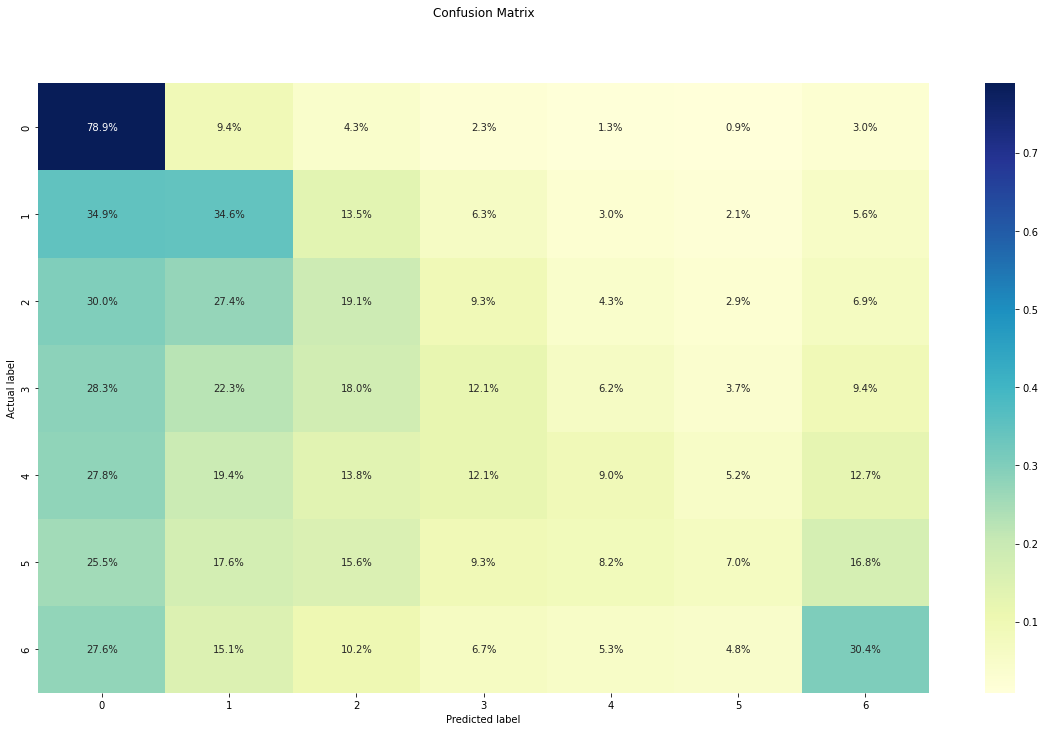